In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
from pylab import figure, subplot, text, xlim, ylim, title, plot, axvline, ylabel, xlabel, legend
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, describe, spearmanr
import scipy.stats as stats
import statsmodels.api as sm
import pylab as py

In [2]:
import os
os.environ['PATH'] = "/software/texlive/2020/bin/x86_64-linux:" + os.environ['PATH']

matplotlib.rcParams['text.usetex'] = False

In [3]:
orig_params = pylab.rcParams.copy()
params = {'legend.fontsize': '20',
          'figure.figsize': (15, 10),
          'axes.labelsize': '20',
          'axes.titlesize':'25',
          'xtick.labelsize':'20',
          'ytick.labelsize':'20',
          'axes.linewidth': '0.5',
          'pdf.fonttype': '42'}
pylab.rcParams.update(params)
# pylab.style.use('seaborn-white')

In [4]:
#PARAM VALS FOR THIS RUN
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_ec50_equals_median_kOn_added/k_Tf_on/samples_replicates_over_time_with_regulation_param_index_9_run_9.csv'
sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/general_simulation_data/r_add_k_on_repression/simulation_matrix101_A-|B_mod_kOn_rAdd_0.00_n_2_max_k_on_B.csv'
# sim_file_use = '/home/mzo5929/Keerthana/grnInference/simulationData/simulations_rerun/with_regulation/median/samples_replicates_with_regulation_median_0.csv'
num_sampling_times = 24
num_cells = 10e3

updated_df = pd.read_csv(sim_file_use)
updated_df

,gene_1_is_bursting,gene_1_unspliced_mRNA,gene_1_spliced_mRNA,gene_1_protein,gene_1_k_on_adjusted,gene_1_k_off_adjusted,gene_1_total_mRNA,gene_1_mRNA_ever_produced,gene_1_protein_ever_produced,gene_2_is_bursting,...,gene_2_spliced_mRNA,gene_2_protein,gene_2_k_on_adjusted,gene_2_k_off_adjusted,gene_2_total_mRNA,gene_2_mRNA_ever_produced,gene_2_protein_ever_produced,cell_id,timestep,replicate
0,0.0,2.083993e-01,162.031601,83.516788,0.27,0.0,162.240000,3140.48,607.067203,0.0,...,0.0,0.062245,1.000000e-10,0.0,0.0,0.0,0.0,0,0,0
1,0.0,1.650030e-12,11.897806,87.959641,0.27,0.0,11.897806,2638.72,549.568008,0.0,...,0.0,0.000000,1.000000e-10,0.0,0.0,0.0,0.0,1,0,0
2,0.0,3.459458e-41,0.548760,72.215504,0.27,0.0,0.548760,2929.92,588.750727,0.0,...,0.0,0.149984,1.000000e-10,0.0,0.0,0.0,0.0,2,0,0
3,1.0,5.642181e+00,60.703828,104.190140,0.27,0.0,66.346009,2499.84,508.045934,0.0,...,0.0,0.121320,1.000000e-10,0.0,0.0,0.0,0.0,3,0,0
4,0.0,1.339521e-19,3.680000,51.957996,0.27,0.0,3.680000,2213.12,462.616520,0.0,...,0.0,0.000000,1.000000e-10,0.0,0.0,0.0,0.0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.0,4.353252e-02,134.251273,113.803976,0.27,0.0,134.294805,3256.96,621.946015,0.0,...,0.0,0.000000,1.000000e-10,0.0,0.0,0.0,0.0,9995,1440,1
499996,0.0,4.314505e-27,6.253442,86.089650,0.27,0.0,6.253442,2791.04,571.608981,0.0,...,0.0,0.009028,1.000000e-10,0.0,0.0,0.0,0.0,9996,1440,1
499997,0.0,3.776766e-06,19.969748,80.028869,0.27,0.0,19.969752,3189.76,642.466543,0.0,...,0.0,0.000000,1.000000e-10,0.0,0.0,0.0,0.0,9997,1440,1
499998,0.0,1.628430e-02,36.407843,44.682792,0.27,0.0,36.424127,2396.80,478.148963,0.0,...,0.0,0.036144,1.000000e-10,0.0,0.0,0.0,0.0,9998,1440,1


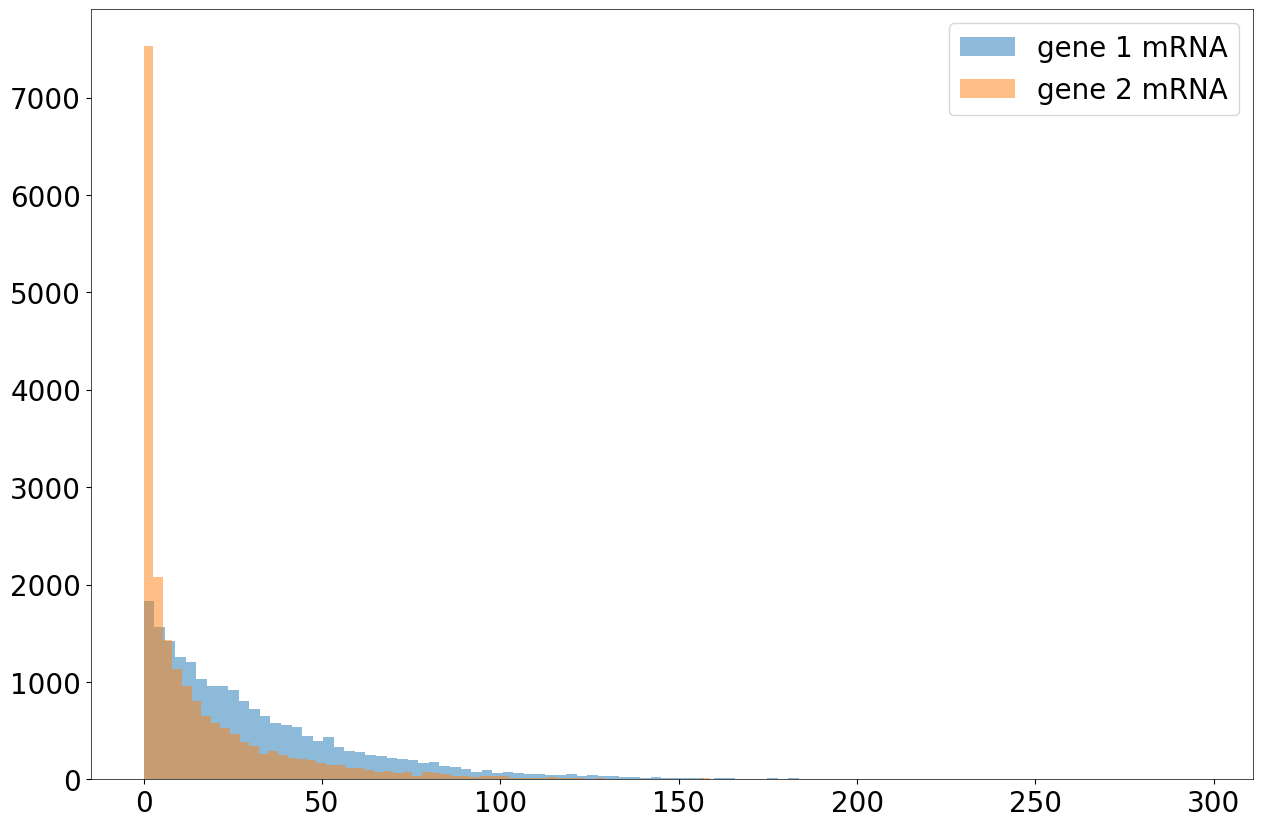

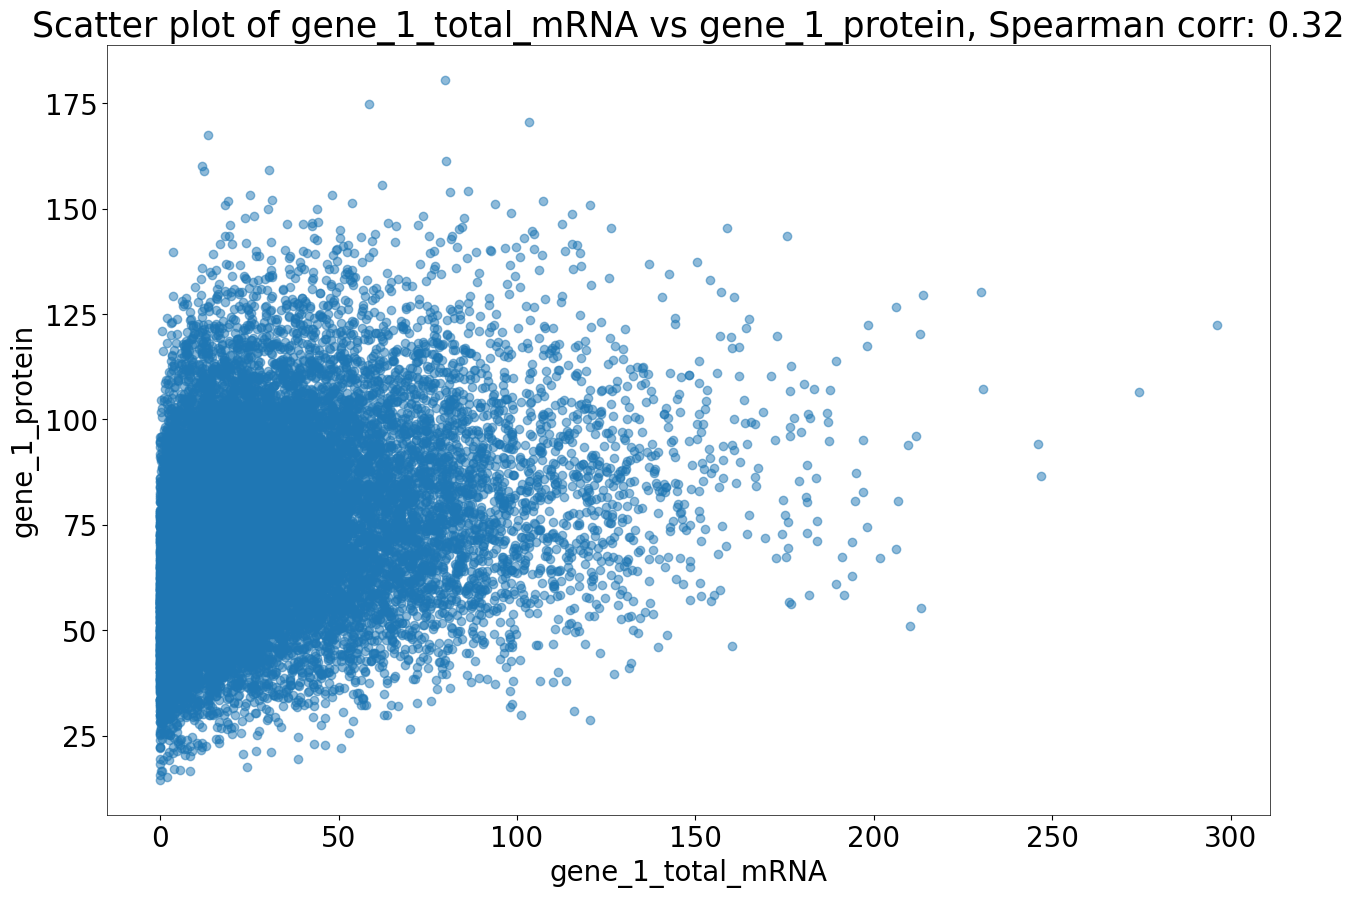

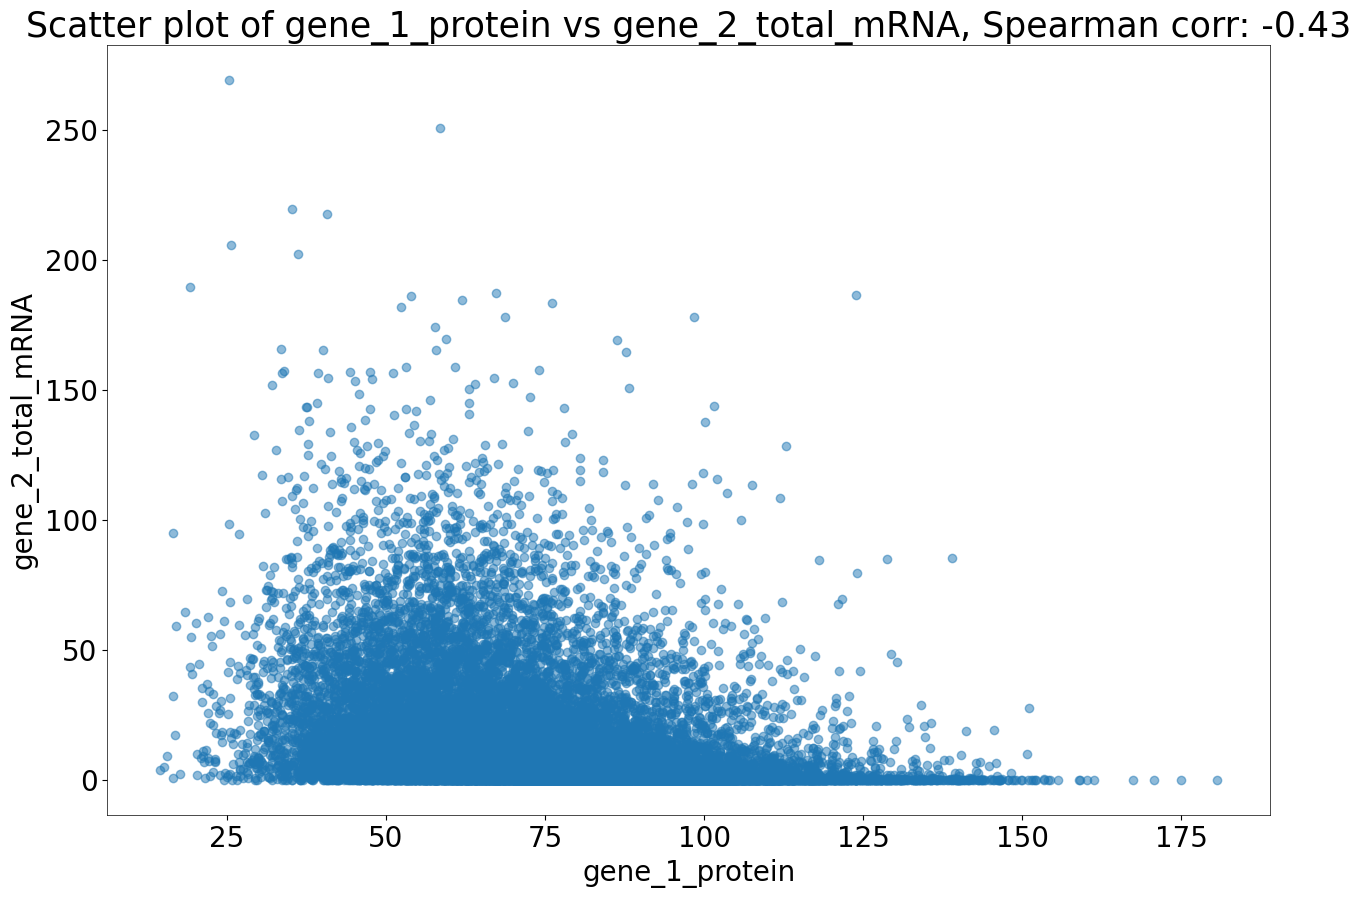

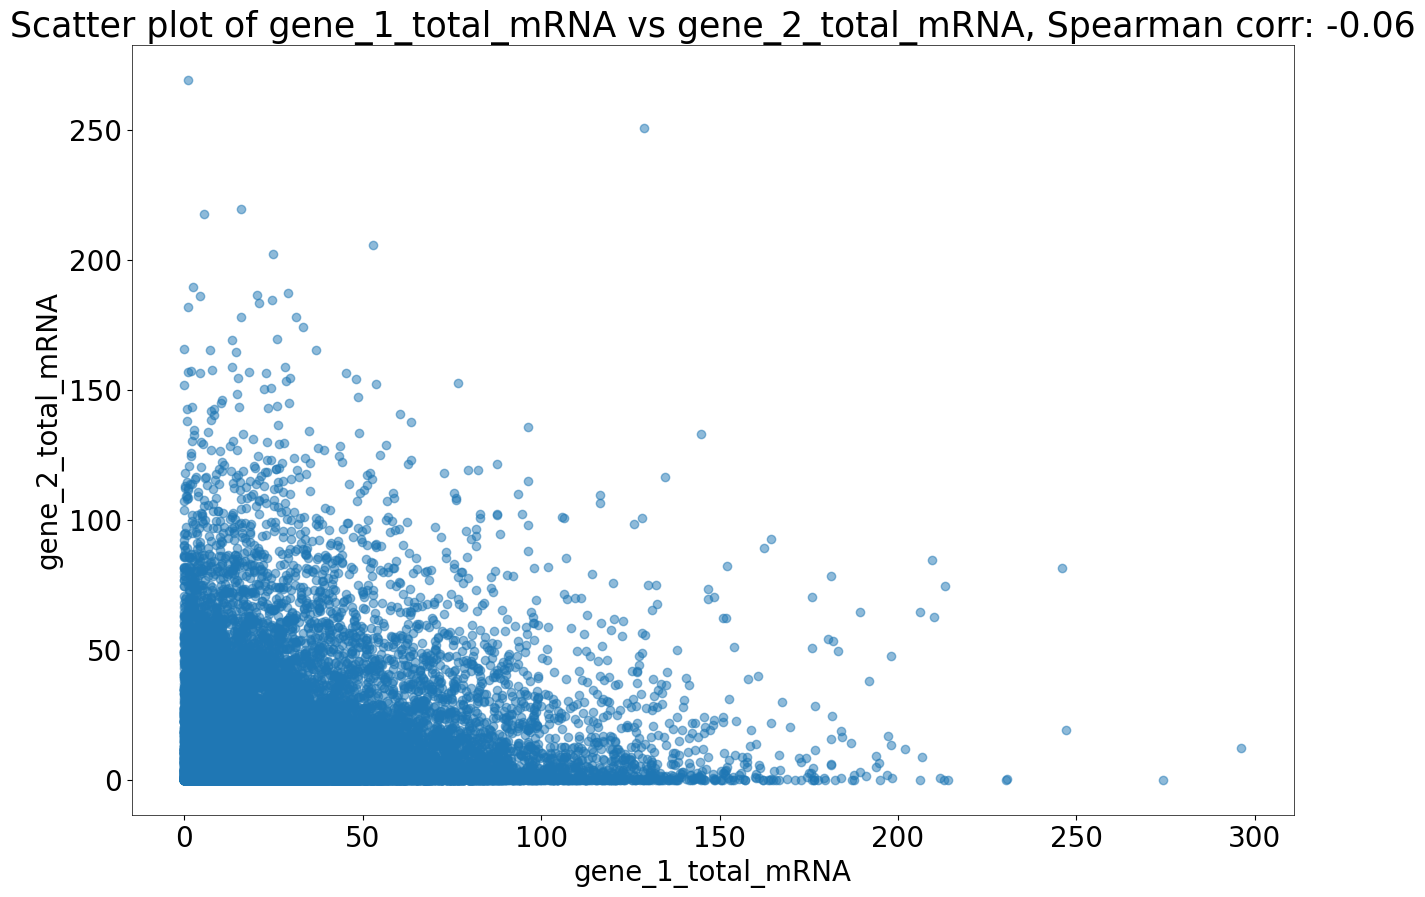

In [25]:
#First compare regulation
time = 300
singleTime_df = updated_df[updated_df['timestep'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)


plt.hist(singleTime_df['gene_1_total_mRNA'], bins=100, alpha=0.5, label='gene 1 mRNA')
plt.hist(singleTime_df['gene_2_total_mRNA'], bins=100, alpha=0.5, label='gene 2 mRNA')
plt.legend(loc='upper right')
plt.show()

plt.scatter(singleTime_df['gene_1_total_mRNA'], singleTime_df['gene_1_protein'], alpha=0.5)
corr = spearmanr(singleTime_df['gene_1_total_mRNA'], singleTime_df['gene_1_protein'])
plt.ylabel('gene_1_protein')
plt.xlabel('gene_1_total_mRNA')
plt.title('Scatter plot of gene_1_total_mRNA vs gene_1_protein, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

plt.scatter(singleTime_df['gene_1_protein'], singleTime_df['gene_2_total_mRNA'], alpha=0.5)
corr = spearmanr(singleTime_df['gene_1_protein'], singleTime_df['gene_2_total_mRNA'])
plt.ylabel('gene_2_total_mRNA')
plt.xlabel('gene_1_protein')
plt.title('Scatter plot of gene_1_protein vs gene_2_total_mRNA, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

plt.scatter(singleTime_df['gene_1_total_mRNA'], singleTime_df['gene_2_total_mRNA'], alpha=0.5)
corr = spearmanr(singleTime_df['gene_1_total_mRNA'], singleTime_df['gene_2_total_mRNA'])
plt.ylabel('gene_2_total_mRNA')
plt.xlabel('gene_1_total_mRNA')
plt.title('Scatter plot of gene_1_total_mRNA vs gene_2_total_mRNA, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

In [ ]:
#First compare regulation
time = 300
singleTime_df = updated_df[updated_df['timestep'] == time]
singleTime_df = singleTime_df.reset_index(drop=True)

plt.hist(singleTime_df['gene_2_total_mRNA'], bins=100, alpha=0.5, label='gene 2 mRNA')
plt.hist(singleTime_df['gene_3_total_mRNA'], bins=100, alpha=0.5, label='gene 3 mRNA')
plt.legend(loc='upper right')
plt.show()

plt.scatter(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_2_protein'], alpha=0.5)
corr = spearmanr(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_2_protein'])
plt.ylabel('gene_1_protein')
plt.xlabel('gene_1_total_mRNA')
plt.title('Scatter plot of gene_1_total_mRNA vs gene_1_protein, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

plt.scatter(singleTime_df['gene_2_protein'], singleTime_df['gene_3_total_mRNA'], alpha=0.5)
corr = spearmanr(singleTime_df['gene_2_protein'], singleTime_df['gene_3_total_mRNA'])
plt.ylabel('gene_3_total_mRNA')
plt.xlabel('gene_2_protein')
plt.title('Scatter plot of gene_2_protein vs gene_3_total_mRNA, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

plt.scatter(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_3_total_mRNA'], alpha=0.5)
corr = spearmanr(singleTime_df['gene_2_total_mRNA'], singleTime_df['gene_3_total_mRNA'])
plt.ylabel('gene_3_total_mRNA')
plt.xlabel('gene_2_total_mRNA')
plt.title('Scatter plot of gene_2_total_mRNA vs gene_3_total_mRNA, Spearman corr: {:.2f}'.format(corr.correlation))
plt.show()

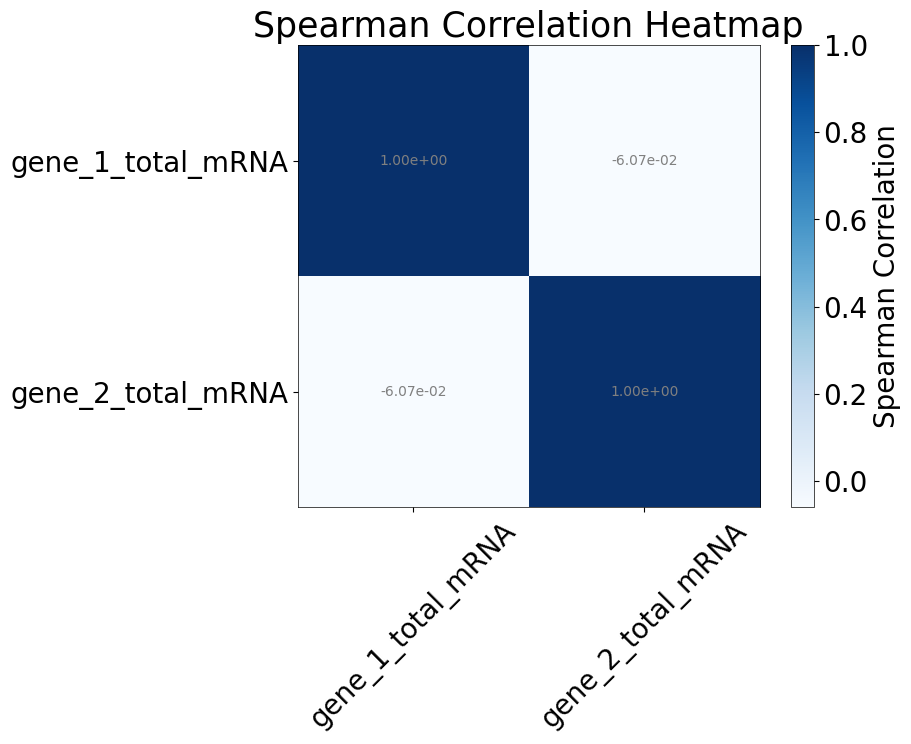

In [26]:
# BEGIN: Generate correlation matrix and plot heatmap with labels
# Ensure the correlation matrix contains numeric values
time = 300
singleTime_df = updated_df[updated_df['timestep'] == time]
n_genes = 2
columns_interest = ['gene_{}_total_mRNA'.format(i) for i in range(1, n_genes + 1)]
correlation_matrix = singleTime_df[columns_interest].corr(method='spearman')
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Spearman Correlation')
plt.xticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns, rotation=45)
plt.yticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.index)
plt.title('Spearman Correlation Heatmap')

# Annotate the heatmap with correlation values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2e}",
                 ha="center", va="center", color="grey")

plt.show()
# END: Generate correlation matrix and plot heatmap with labels


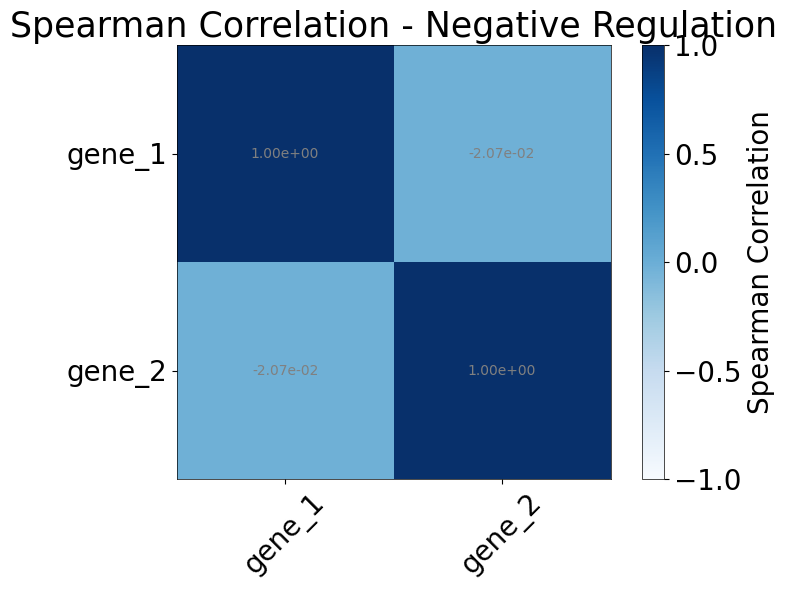

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ----- Parameters -----
time = 300
n_genes = 2
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
columns_interest = [f"{gene}_total_mRNA" for gene in gene_list]

# Assume updated_df is already defined and contains 'replicate', 'timestep', and mRNA columns
singleTime_df = updated_df[updated_df['timestep'] == time]

# Split into replicates
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 0].reset_index(drop=True)
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)

# ----- Step 1: Compute correlations -----
def calculate_correlation(rep_0, rep_1):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_total_mRNA"] - rep_1[f"{gene_1}_total_mRNA"]
            delta_2 = rep_0[f"{gene_2}_total_mRNA"] - rep_1[f"{gene_2}_total_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

# ----- Step 2: Convert to matrix -----
def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix

# Compute correlation matrix
correlation_dict = calculate_correlation(rep_0_t1, rep_1_t1)
correlation_matrix = dict_to_matrix(correlation_dict, gene_list)

# ----- Step 3: Plot heatmap -----
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix.values, interpolation='nearest', cmap='Blues', vmin=-1, vmax=1)
plt.colorbar(label='Spearman Correlation')
plt.xticks(ticks=range(len(gene_list)), labels=gene_list, rotation=45)
plt.yticks(ticks=range(len(gene_list)), labels=gene_list)
plt.title('Spearman Correlation - Negative Regulation')

# Annotate each cell with correlation value
for i in range(len(gene_list)):
    for j in range(len(gene_list)):
        val = correlation_matrix.iloc[i, j]
        if pd.notnull(val):
            plt.text(j, i, f"{val:.2e}", ha='center', va='center', color='grey')

plt.tight_layout()
plt.show()


In [10]:
updated_df['timestep'].unique()

array([17279,    60,   120,   180,   240,   300,   360,   420,   480,
         540,   600,   660,   720,   780,   840,   900,   960,  1020,
        1080,  1140,  1200,  1260,  1320,  1380])

In [18]:
time_points = updated_df['timestep'].unique()
time_points

array([17279,    60,   120,   180,   240,   300,   360,   420,   480,
         540,   600,   660,   720,   780,   840,   900,   960,  1020,
        1080,  1140,  1200,  1260,  1320,  1380])

/home/mzo5929/.conda/envs/grnSimulationQuest/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


[   0   60  120  180  240  300  360  420  480  540  600  660  720  780
  840  900  960 1020 1080 1140 1200 1260 1320 1380 1440]


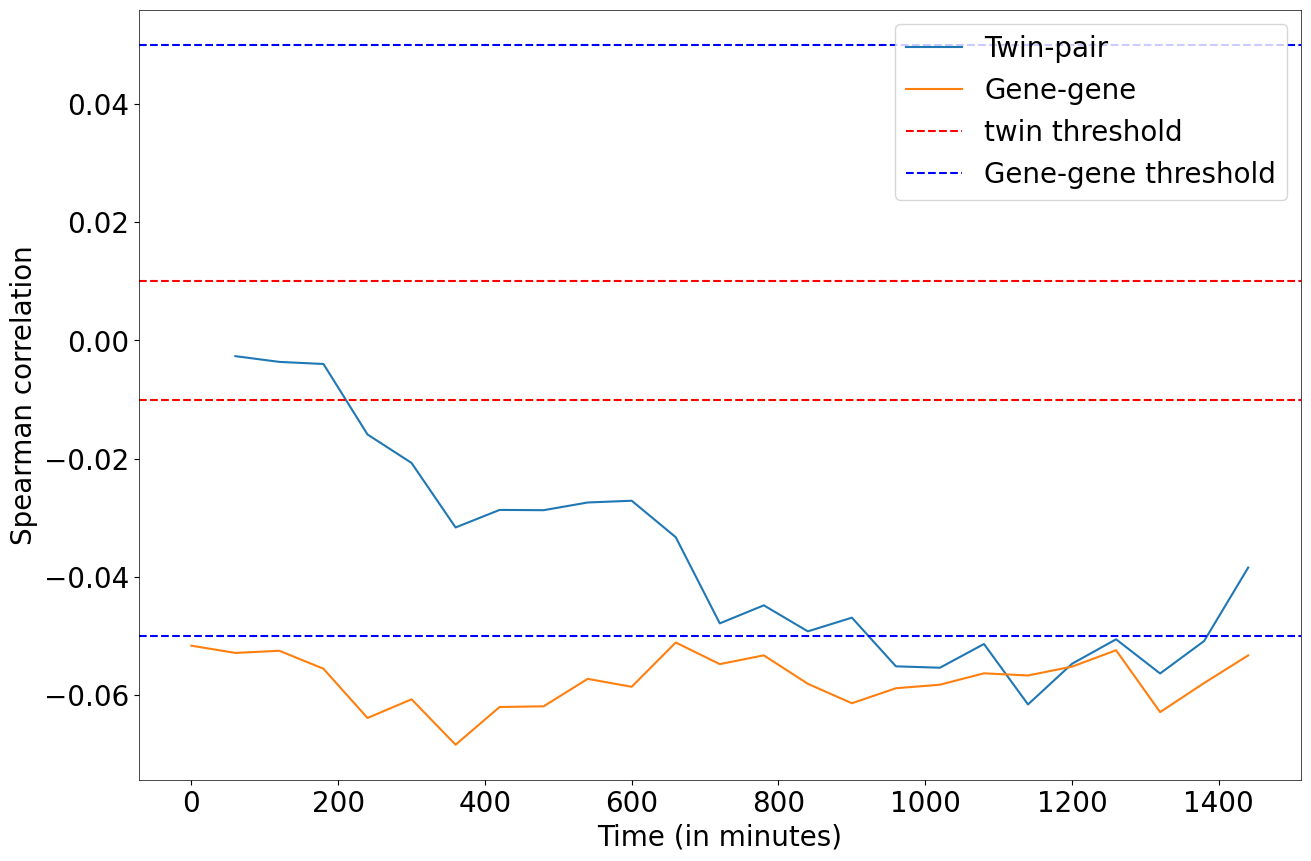

In [24]:
updated_df = updated_df[updated_df['timestep'] < 1500]
time_points = updated_df['timestep'].unique()
n_genes = 2
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
columns_interest = [f"{gene}_total_mRNA" for gene in gene_list]
corr_list = []
gene_corr = []
# ----- Step 1: Compute correlations -----
def calculate_correlation(rep_0, rep_1):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_total_mRNA"] - rep_1[f"{gene_1}_total_mRNA"]
            delta_2 = rep_0[f"{gene_2}_total_mRNA"] - rep_1[f"{gene_2}_total_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

# ----- Step 2: Convert to matrix -----
def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix

for time in time_points:
    if time > 1500:
        continue
    # Assume updated_df is already defined and contains 'replicate', 'timestep', and mRNA columns
    singleTime_df = updated_df[updated_df['timestep'] == time]
    gene_gene_corr = spearmanr(singleTime_df['gene_1_total_mRNA'], singleTime_df['gene_2_total_mRNA']).correlation
    # Split into replicates
    rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 0].reset_index(drop=True)
    rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 1].reset_index(drop=True)


    # Compute correlation matrix
    correlation_dict = calculate_correlation(rep_0_t1, rep_1_t1)
    corr_list.append(correlation_dict['gene_1-gene_2'])
    gene_corr.append(gene_gene_corr)
print(time_points)
plt.plot(time_points, corr_list, label = "Twin-pair")
plt.plot(time_points, gene_corr, label = "Gene-gene")
plt.xlabel('Time (in minutes)')
plt.ylabel('Spearman correlation')
plt.axhline(0.01, linestyle = "--",  color = "red",label = "twin threshold")
plt.axhline(-0.01, linestyle = "--",  color = "red",)
plt.axhline(0.05, linestyle = "--", color = "blue", label = "Gene-gene threshold")
plt.axhline(-0.05, linestyle = "--", color = "blue",)
plt.legend()
plt.show()


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def plot_gene_correlation_network(correlation_matrix, gene_list, title="Gene Correlation Network"):
    """
    Plots a directed gene correlation network from a square correlation matrix.
    - Nodes are colored by their self-correlation (gene -> gene)
    - Outgoing edge weights are normalized by the self-correlation of the source node
    """
    # Create directed graph
    DG = nx.DiGraph()

    # Add nodes
    for gene in gene_list:
        DG.add_node(gene)

    # Add normalized directed edges with weights
    for gene_1 in gene_list:
        self_corr = correlation_matrix.loc[gene_1, gene_1]
        if self_corr == 0 or np.isnan(self_corr):
            continue  # Avoid division by zero
        for gene_2 in gene_list:
            if gene_1 == gene_2:
                continue
            raw_weight = correlation_matrix.loc[gene_1, gene_2]
            if pd.isnull(raw_weight):
                continue
            norm_weight = raw_weight / self_corr
            if abs(raw_weight) > 0.0:
                DG.add_edge(gene_1, gene_2, weight=norm_weight)

    # Position nodes using circular layout
    pos = nx.circular_layout(DG)

    # Node colors from self-correlation
    node_colors = [correlation_matrix.loc[gene, gene] for gene in gene_list]

    fig, ax = plt.subplots(figsize=(9, 9))

    # Draw nodes with color from self-correlation
    nodes = nx.draw_networkx_nodes(
        DG, pos,
        ax=ax,
        node_color=node_colors,
        cmap='Reds',
        node_size=4000,
        edgecolors='black',
        linewidths=1.5,
        alpha=0.5
    )

    # Draw node labels
    nx.draw_networkx_labels(DG, pos, font_size=14, font_weight='bold', ax=ax)

    # Draw directed edges
    # for u, v in DG.edges():
    #     weight = DG[u][v]['weight']
    #     abs_weight = abs(weight)
    #     if abs_weight < 0.0:
    #         weight = 0
    #         DG[u][v]['weight'] = 0
    #     color = 'blue' if weight > 0 else 'red'
    #     rad = 0.25 if DG.has_edge(v, u) else 0.0

    #     nx.draw_networkx_edges(
    #         DG, pos,
    #         edgelist=[(u, v)],
    #         connectionstyle=f'arc3,rad={rad}',
    #         width=abs_weight * 5,
    #         edge_color=color,
    #         arrows=True,
    #         arrowsize=30,
    #         min_source_margin=45,
    #         min_target_margin=30,
    #         ax=ax
    #     )

    # Draw edge labels manually
    drawn = set()
    edge_labels = {(u, v): f"{DG[u][v]['weight']:.2f}" for u, v in DG.edges()}
    # for (u, v), label_uv in edge_labels.items():
    #     if (u, v) in drawn:
    #         continue

    #     x1, y1 = pos[u]
    #     x2, y2 = pos[v]
    #     mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    #     dx, dy = x2 - x1, y2 - y1
    #     angle = np.arctan2(dy, dx)

    #     offset = 0.1
    #     ox = -offset * np.sin(angle)
    #     oy = offset * np.cos(angle)

    #     ax.text(mid_x - ox, mid_y - oy, label_uv,
    #             fontsize=10, color='black', fontweight='bold',
    #             ha='center', va='center',
    #             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

    #     if (v, u) in edge_labels:
    #         label_vu = edge_labels[(v, u)]
    #         ax.text(mid_x + ox, mid_y + oy, label_vu,
    #                 fontsize=10, color='black', fontweight='bold',
    #                 ha='center', va='center',
    #                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

    #     drawn.add((u, v))
    #     drawn.add((v, u))
    for u, v in DG.edges():
        weight = DG[u][v]['weight']
        abs_weight = abs(weight)
        color = 'blue' if weight > 0 else 'red'
        rad = 0.25 if DG.has_edge(v, u) else 0.0

        if weight > 0:
            print(weight)
            nx.draw_networkx_edges(
                DG, pos,
                edgelist=[(u, v)],
                connectionstyle=f'arc3,rad={rad}',
                width=abs_weight * 5,
                edge_color=color,
                arrows=True,
                arrowsize=30,
                min_source_margin=45,
                min_target_margin=30,
                ax=ax
            )
        else:
            # Draw repression as |-|
            arrow = FancyArrowPatch(
                posA=pos[u],
                posB=pos[v],
                connectionstyle=f'arc3,rad={rad}',
                arrowstyle='|-|',
                mutation_scale=20 + abs_weight * 10,
                color='red',
                linewidth=abs_weight * 5,
                zorder=1
            )
            ax.add_patch(arrow)


    # Properly add colorbar
    # Create colormap with transparency for colorbar
    base_cmap = plt.cm.Reds
    alpha = 0.5
    cmap_with_alpha = base_cmap(np.linspace(0, 1, 256))

    from matplotlib.colors import ListedColormap

    cmap_with_alpha = ListedColormap(cmap_with_alpha)

    cmap_with_alpha = base_cmap(np.linspace(0, 1, 256))
    cmap_with_alpha[:, -1] = alpha
    cmap_with_alpha = ListedColormap(cmap_with_alpha)

    # Create ScalarMappable with new colormap
    sm = plt.cm.ScalarMappable(cmap=cmap_with_alpha, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Self Correlation (gene → gene)', fontsize=12)


    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()



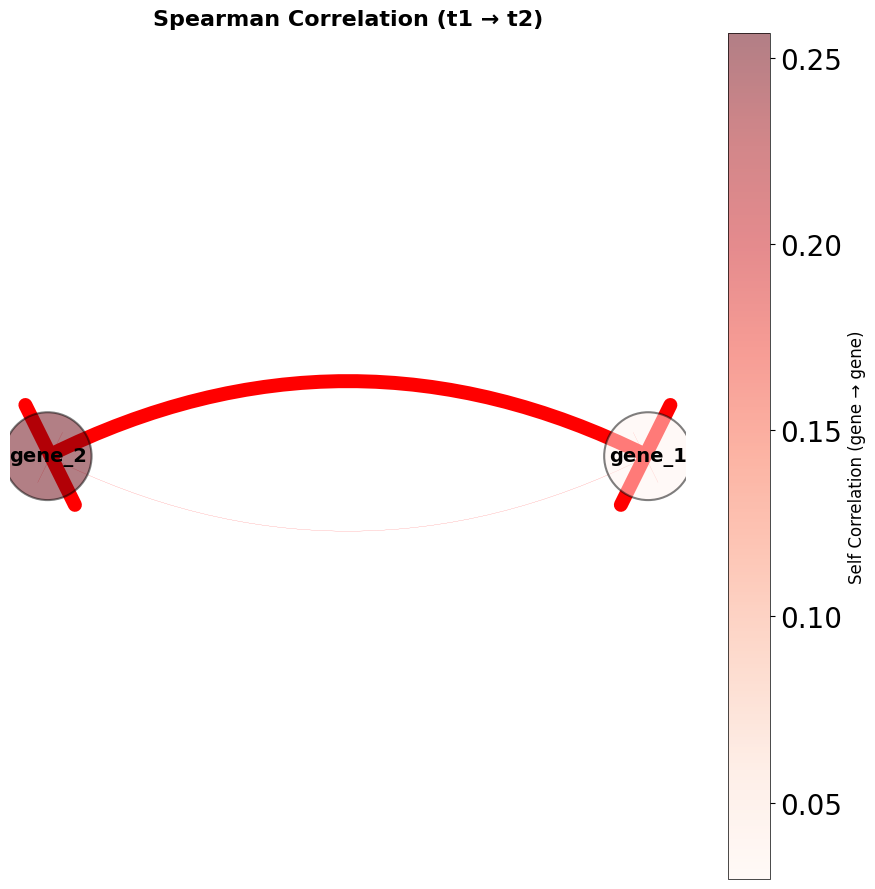

In [30]:
from matplotlib.patches import FancyArrowPatch

t1 = 300
singleTime_df = updated_df[updated_df['timestep'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 0]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 1]
t2 = 600
singleTime_df = updated_df[updated_df['timestep'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 0]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 1]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]

def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix


#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_total_mRNA"], rep_1_t2[f"{gene_2}_total_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

correlations = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
correlation_matrix = dict_to_matrix(correlations, gene_list)
plot_gene_correlation_network(correlation_matrix, gene_list, title="Spearman Correlation (t1 → t2)")

Spearman Correlations between time points:
gene_1->gene_1: 0.04
gene_1->gene_2: -0.01
gene_2->gene_1: -0.01
gene_2->gene_2: 0.03


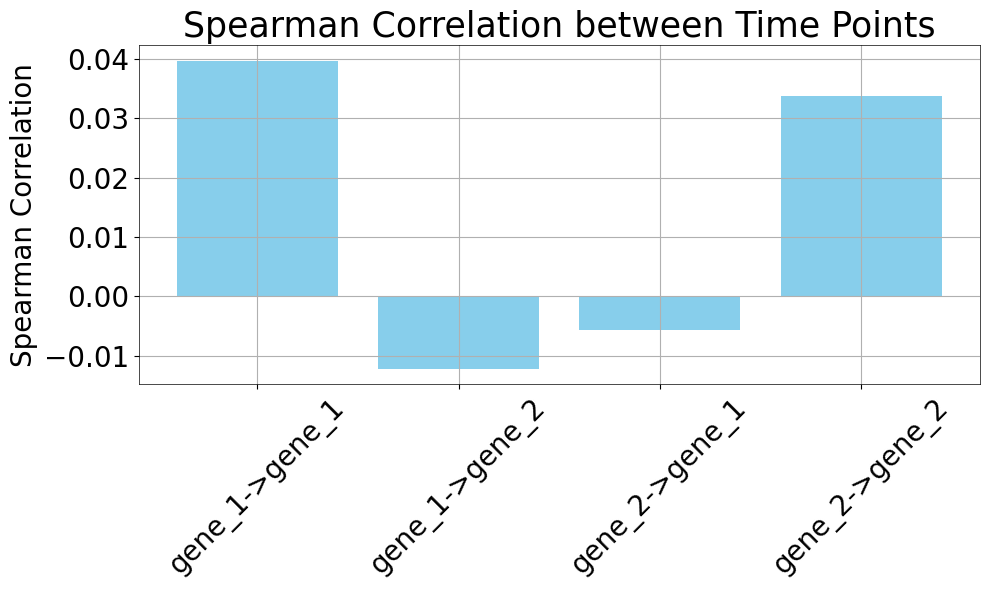

In [29]:
t1 = 300
singleTime_df = updated_df[updated_df['timestep'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 0]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 1]
t2 = 600
singleTime_df = updated_df[updated_df['timestep'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 0]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 1]
n_genes = 2
gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]
#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_total_mRNA"], rep_1_t2[f"{gene_2}_total_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    for gene_1 in gene_list:
        for gene_2 in gene_list:
    #         correlations_normalised[f"{gene_1}->{gene_2}"] = correlations[f"{gene_1}->{gene_2}"]/correlations[f"{gene_1}->{gene_1}"]
            correlations_normalised[f"{gene_1}->{gene_2}"] = correlations[f"{gene_1}->{gene_2}"]

    return correlations, correlations_normalised

correlations, correlations_normalised = calculate_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2)
# Print the correlations
print("Spearman Correlations between time points:")
for gene, corr in correlations_normalised.items():
    print(f"{gene}: {corr:.2f}")
# Plotting the correlations
plt.figure(figsize=(10, 6))
plt.bar(correlations_normalised.keys(), correlations_normalised.values(), color='skyblue')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation between Time Points')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()
# #Plot it as a matrix
# correlation_matrix = pd.DataFrame(correlations_normalised)
# # for gene_1 in gene_list:
# #     for gene_2 in gene_list:
# #         corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_total_mRNA"], rep_1_t2[f"{gene_2}_total_mRNA"]).correlation
# #         correlation_matrix.loc[gene_1, gene_2] = corr_t1_t2

# import matplotlib.pyplot as plt
# import networkx as nx
# import numpy as np

# # Create directed graph
# DG = nx.DiGraph()

# # Add nodes
# for gene in gene_list:
#     DG.add_node(gene)

# # Add directed edges with weights
# for gene_1 in gene_list:
#     for gene_2 in gene_list:
#         if gene_1 != gene_2:
#             weight = correlation_matrix.loc[gene_1, gene_2]
#             DG.add_edge(gene_1, gene_2, weight=weight)

# # Circular layout
# pos = nx.circular_layout(DG)

# plt.figure(figsize=(8, 8))
# nx.draw_networkx_nodes(DG, pos, node_color='skyblue', node_size=1000)
# nx.draw_networkx_labels(DG, pos, font_size=10, font_weight='bold')

# # Draw curved edges with arrowheads
# for u, v in DG.edges():
#     weight = abs(DG[u][v]['weight']) * 20
#     color = 'blue' if DG[u][v]['weight'] > 0 else 'red'
#     rad = 0.2 if DG.has_edge(v, u) else 0.0

#     nx.draw_networkx_edges(
#         DG, pos,
#         edgelist=[(u, v)],
#         connectionstyle=f'arc3,rad={rad}',
#         width=weight,
#         edge_color=color,
#         arrows=True,
#         arrowsize=25
#     )

# # Manually compute offset label positions
# label_pos = {}
# offset_scale = 0.08
# for u, v in DG.edges():
#     x1, y1 = pos[u]
#     x2, y2 = pos[v]
#     dx, dy = x2 - x1, y2 - y1
#     angle = np.arctan2(dy, dx)
#     offset_x = -offset_scale * np.sin(angle)
#     offset_y = offset_scale * np.cos(angle)
#     if DG.has_edge(v, u) and (v, u) in label_pos:
#         offset_x *= -1
#         offset_y *= -1
#     label_pos[(u, v)] = ((x1 + x2) / 2 + offset_x, (y1 + y2) / 2 + offset_y)

# # Draw edge labels manually using ax.text
# edge_labels = {(u, v): f"{d['weight']:.2e}" for u, v, d in DG.edges(data=True)}
# # Updated label draw loop
# # Draw two separate edge labels for each direction
# ax = plt.gca()
# drawn = set()
# for (u, v), label_uv in edge_labels.items():
#     if (u, v) in drawn:
#         continue

#     # Positions
#     x1, y1 = pos[u]
#     x2, y2 = pos[v]
#     mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
#     dx, dy = x2 - x1, y2 - y1
#     angle = np.arctan2(dy, dx)

#     # Perpendicular offset
#     offset = 0.1
#     ox = -offset * np.sin(angle)
#     oy = offset * np.cos(angle)

#     # Label for u → v
#     label_uv = edge_labels[(u, v)]
#     ax.text(
#         mid_x - ox, mid_y - oy,
#         label_uv,
#         fontsize=10, color='black', fontweight='bold',
#         ha='center', va='center',
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
#     )

#     # Label for v → u, if it exists
#     if (v, u) in edge_labels:
#         label_vu = edge_labels[(v, u)]
#         ax.text(
#             mid_x + ox, mid_y + oy,
#             label_vu,
#             fontsize=10, color='black', fontweight='bold',
#             ha='center', va='center',
#             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
#         )

#     drawn.add((u, v))
#     drawn.add((v, u))



# plt.title('Gene Correlation Network Multiplicative regulation', fontsize=14)
# plt.axis('off')
# plt.tight_layout()
# plt.show()



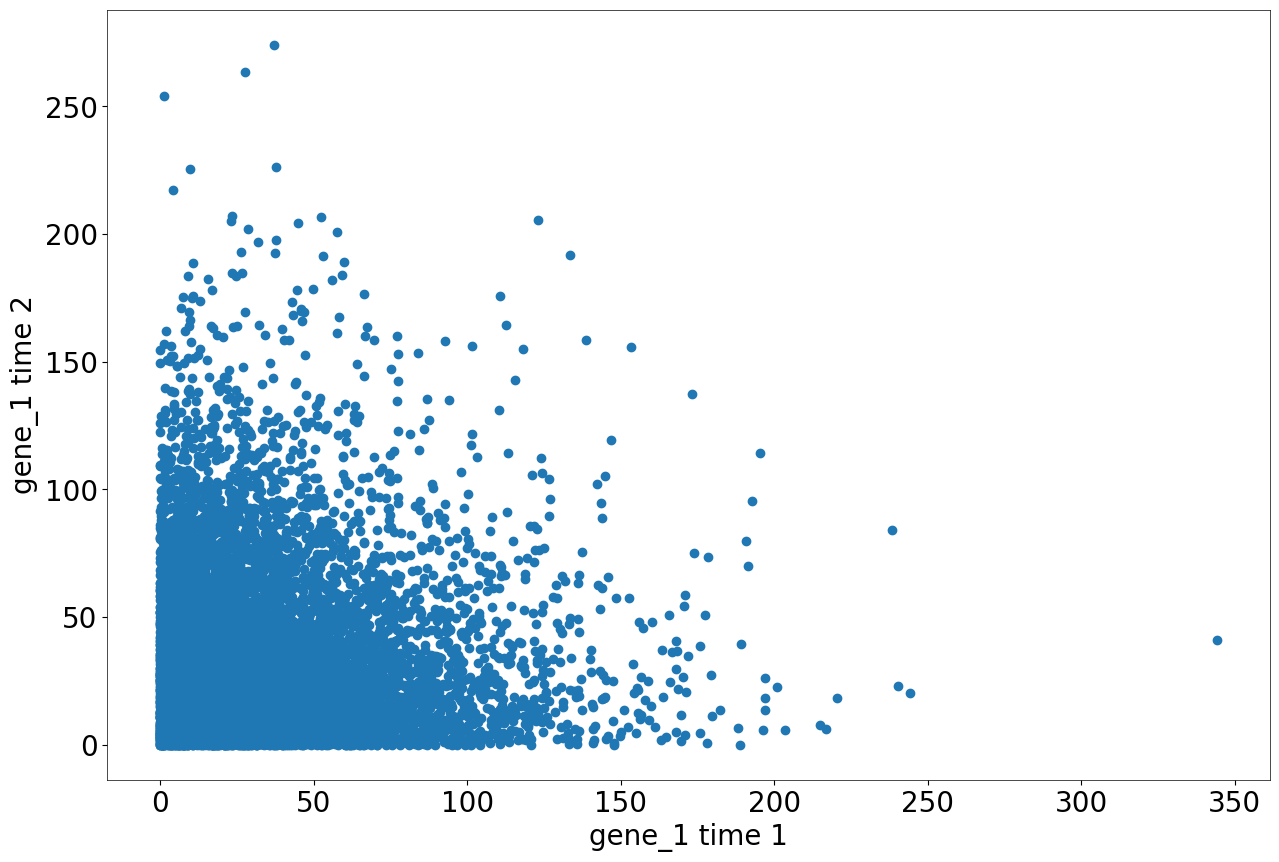

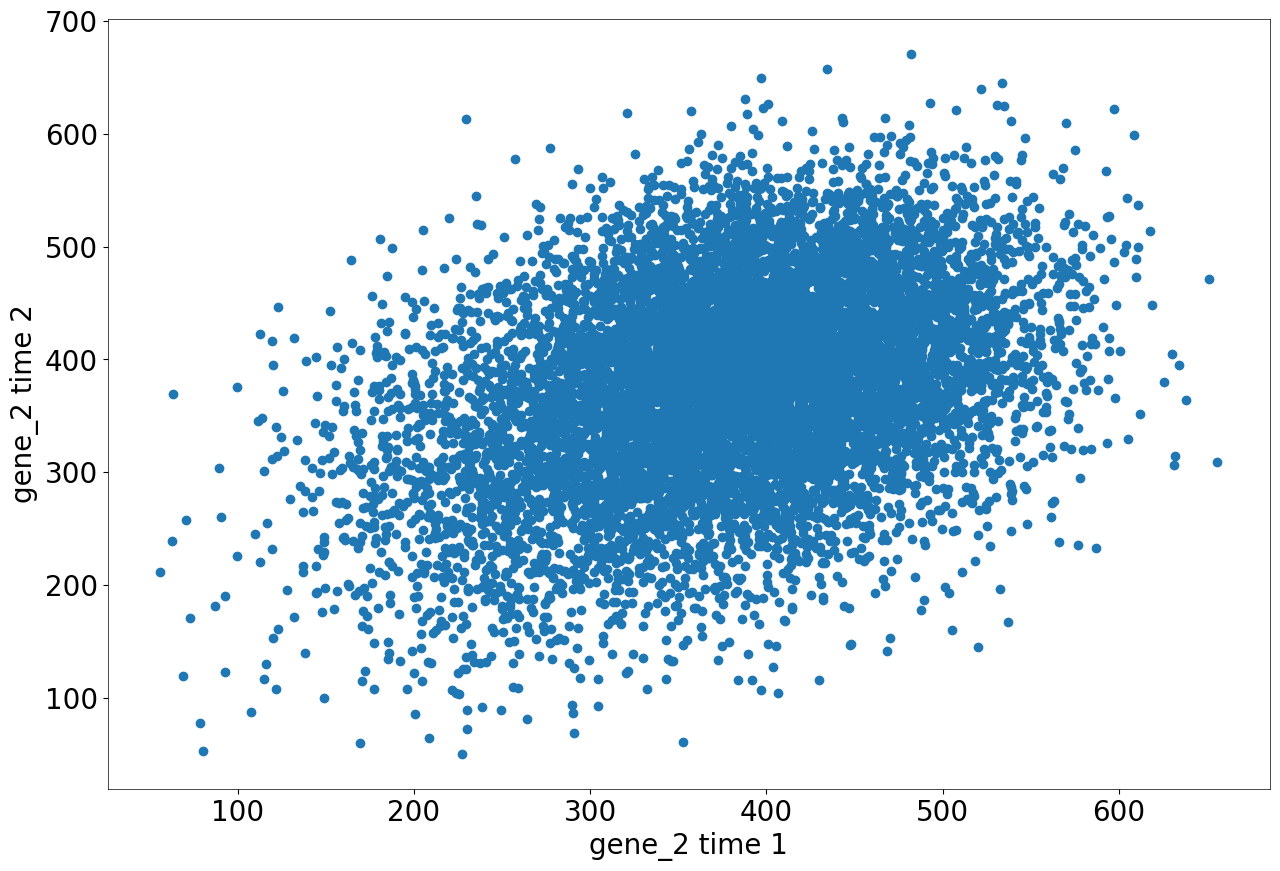

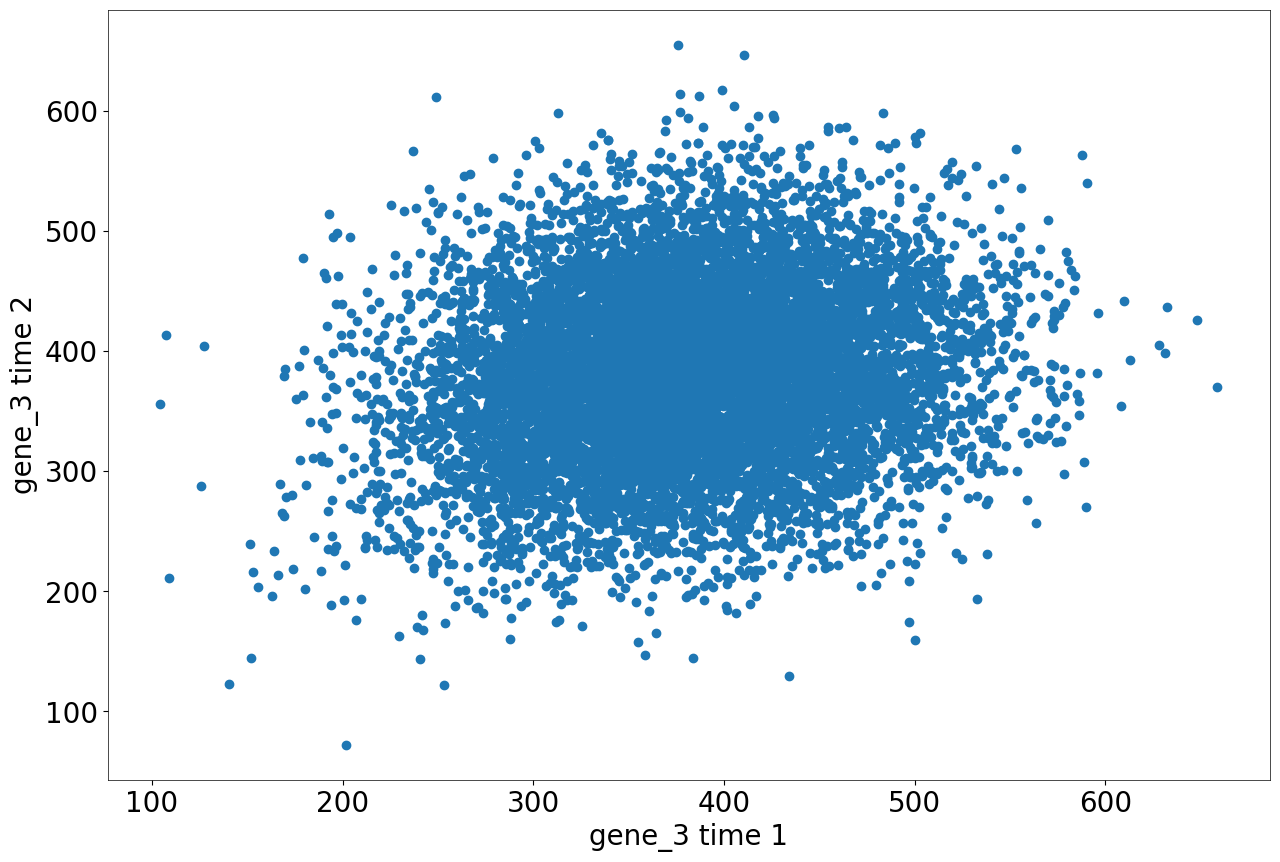

In [70]:
t1 = 600
singleTime_df = updated_df[updated_df['timestep'] == t1]
rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 0]
rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 1]
t2 = 900
singleTime_df = updated_df[updated_df['timestep'] == t2]
rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 0]
rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 1]
plt.scatter(rep_0_t1['gene_1_total_mRNA'], rep_1_t2['gene_1_total_mRNA'])
plt.xlabel("gene_1 time 1")
plt.ylabel("gene_1 time 2")
plt.show()
plt.scatter(rep_0_t1['gene_2_total_mRNA'], rep_1_t2['gene_2_total_mRNA'])
plt.xlabel("gene_2 time 1")
plt.ylabel("gene_2 time 2")
plt.show()
plt.scatter(rep_0_t1['gene_3_total_mRNA'], rep_1_t2['gene_3_total_mRNA'])
plt.xlabel("gene_3 time 1")
plt.ylabel("gene_3 time 2")
plt.show()


In [29]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

# --- Setup ---
t1 = 300
t2 = 600
n_genes = 3
gene_list = [f"gene_{i}" for i in range(1, n_genes + 1)]
control_gene = "gene_3"

# --- Subset the data ---
rep_0_t1 = updated_df[(updated_df['timestep'] == t1) & (updated_df['replicate'] == 0)]
rep_1_t2 = updated_df[(updated_df['timestep'] == t2) & (updated_df['replicate'] == 1)]

# --- Helper: regress out control from target (on ranked data) ---
def get_residuals_ranked(target, control):
    target_rank = target.rank().values
    control_rank = control.rank().values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(control_rank, target_rank)
    return target_rank - model.predict(control_rank)

# --- Compute partial Spearman correlations ---
def calculate_partial_spearman_matrix(rep_0_t1, rep_1_t2, gene_list, control_gene):
    partial_corrs = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            # Get expression
            x = rep_0_t1[f"{gene_1}_total_mRNA"]
            y = rep_1_t2[f"{gene_2}_total_mRNA"]
            z = rep_0_t1[f"{control_gene}_total_mRNA"]

            # Residuals after regressing out z (ranked)
            x_resid = get_residuals_ranked(x, z)
            y_resid = get_residuals_ranked(y, z)

            # Compute Spearman correlation on residuals
            if np.std(x_resid) == 0 or np.std(y_resid) == 0:
                rho = np.nan
            else:
                rho = spearmanr(x_resid, y_resid).correlation

            partial_corrs[f"{gene_1}->{gene_2}"] = rho
    return partial_corrs

# --- Run computation ---
partial_corrs = calculate_partial_spearman_matrix(rep_0_t1, rep_1_t2, gene_list, control_gene)

# --- Print output ---
print(f"Partial Spearman Correlations (regressing out {control_gene}@t1):")
for key, value in partial_corrs.items():
    print(f"{key}: {value:.2f}")

# --- Optional: convert to matrix ---
partial_corr_matrix = pd.DataFrame(index=gene_list, columns=gene_list)
for gene_1 in gene_list:
    for gene_2 in gene_list:
        key = f"{gene_1}->{gene_2}"
        partial_corr_matrix.loc[gene_1, gene_2] = partial_corrs.get(key)

print("\nPartial Correlation Matrix:")
print(partial_corr_matrix)


Partial Spearman Correlations (regressing out gene_3@t1):
gene_1->gene_1: 0.46
gene_1->gene_2: 0.42
gene_1->gene_3: 0.01
gene_2->gene_1: 0.41
gene_2->gene_2: 0.38
gene_2->gene_3: 0.01
gene_3->gene_1: nan
gene_3->gene_2: nan
gene_3->gene_3: nan

Partial Correlation Matrix:
          gene_1    gene_2    gene_3
gene_1  0.459411  0.422132  0.013863
gene_2  0.413438  0.379639  0.012476
gene_3       NaN       NaN       NaN
